In [1]:
!pip install transformers

In [2]:
import os
import json
import matplotlib.pyplot as plt
import cv2
import shutil
from PIL import Image
import tqdm
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import vgg19, resnet18, densenet161

import transformers
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW, SGD, Adam

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import pickle

/opt/anaconda3/envs/gradcam_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using TensorFlow backend.


In [3]:
# Global Path Vairables
ROOT_DIR =  "../Dataset/"
DATASET_DIR = ROOT_DIR

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-4 # 2e-4
HIDDEN_DIM = 128 # 64
N_LAYERS = 8 # 2
EPOCHS = 40
DROPOUT = 0.1
BATCH_SIZE = 64 # 32

In [5]:
class MultimodalMnistDataset(Dataset):
  """Dataset containing pairs of MNIST collaged images and text descriptions."""
  def __init__(self, images, texts, labels):
    super(MultimodalMnistDataset, self).__init__()
    self.images = [np.expand_dims(img.astype(np.float32) / 255, 0) for img in images]
    self.texts = texts
    self.labels = labels
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.images[idx], self.texts[idx], self.labels[idx]


In [6]:
# texts = [" ".join(list(map(str, x.tolist()))) for x in dataset["text"]]
dataset = pickle.load(open(DATASET_DIR + 'collaged_MNIST_multitasks.p','rb'))
texts = [x for x in dataset["text"]]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

tokenized_texts = tokenizer.texts_to_sequences(texts)
tokenized_texts = pad_sequences(tokenized_texts, maxlen=2)
mnist_dataset = MultimodalMnistDataset(dataset["image"],
                                      #  dataset["text"],
                                       tokenized_texts,
                                       dataset["label"])
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE)
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [7]:
reverse_word_map

{1: 'the',
 2: 'number',
 3: 'is',
 4: 'at',
 5: 'corner',
 6: 'upper',
 7: 'there',
 8: 'in',
 9: 'image',
 10: 'left',
 11: 'on',
 12: 'half',
 13: 'odd',
 14: 'even',
 15: 'are',
 16: 's',
 17: 'first',
 18: 'right',
 19: 'largest',
 20: 'smallest',
 21: 'bottom',
 22: 'and',
 23: '2',
 24: 'no',
 25: '3',
 26: '1',
 27: '4'}

In [12]:
model = MultimodalMnistClassifier(30, 300, HIDDEN_DIM, N_LAYERS, 1)
model.to(DEVICE)
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [13]:
class MultimodalMnistClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_hidden, n_layers, n_out):
    super(MultimodalMnistClassifier, self).__init__()
    # LSTM
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    self.emb = nn.Embedding(vocab_size, embedding_dim)
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(0.1)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)

    # CNN
    self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
    self.conv2 = nn.Sequential(         
        nn.Conv2d(16, 32, 5, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )

    self.conv3 = nn.Sequential(         
        nn.Conv2d(32, 64, 5, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )

    self.conv4 = nn.Sequential(         
        nn.Conv2d(64, 32, 3, 1, 2),     
        nn.ReLU(),                      
        nn.MaxPool2d(2),                
    )
    # Concat
    self.combined_fc = nn.Linear(640, 128)
    self.output_fc = nn.Linear(128, n_out)

    # placeholder for raw inputs
    self.raw_image_input = None
    self.raw_language_input = None
    
    # placeholder for the gradients
    self.vision_gradients = None
    self.language_gradients = None


  def forward(self, cnn_inp, lstm_inp):
    # CNN Branch
    self.raw_image_input = cnn_inp.clone().detach().cpu().numpy()
    x = self.conv1(cnn_inp)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    h_vision = x.register_hook(self.vision_activations_hook)
    cnn_out = x.view(x.size(0), -1)
    # LSTM Branch
    self.raw_language_input = lstm_inp.clone().detach().cpu().numpy()
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    h_language = lstm_out.register_hook(self.language_activations_hook)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))
    # Combine two branches
    combined_inp = torch.cat((cnn_out, lstm_out), 1)
    x_comb = F.relu(self.combined_fc(combined_inp))
    out = self.output_fc(x_comb)
    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE))
    return hidden

  # hook for the gradients of the activations
  def vision_activations_hook(self, grad):
      self.vision_gradients = grad
  
  def language_activations_hook(self, grad):
      self.language_gradients = grad
  
  def get_vision_gradient(self):
      return self.vision_gradients

  def get_language_gradient(self):
    return self.language_gradients
  
   # method for the activation exctraction
  def get_vision_activations(self, cnn_inp):
      x = self.conv1(cnn_inp)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      return x.detach().cpu().numpy()
  
  def get_language_activations(self):
    return self.raw_language_input

  def get_raw_vision_input(self):
    return self.raw_image_input

  def get_raw_language_input(self):
    return self.raw_language_input

In [14]:
model.train()
for i in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for cnn, lstm, label in mnist_dataloader:
    lstm_inp, cnn_inp, label = lstm.to(DEVICE), cnn.to(DEVICE), label.to(DEVICE)
    model.zero_grad()
    output = model(cnn_inp, lstm_inp)
    loss = criterion(output.squeeze(), label.float())
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - label.float()).view(-1)
      acc = (1. - acc.sum() / acc.size()[0])
      total_acc_train += acc.item()
      total_loss_train += loss.item()
      print("batch acc: ", acc)
  print("Epoch:", i+1)
  print("Accuracy", total_acc_train / len(mnist_dataloader))
  print("Loss", total_loss_train / len(mnist_dataloader))


batch acc:  tensor(0.4688)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.4062)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.4531)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.4531)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.3594)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.4375)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.4844)
b

batch acc:  tensor(0.5938)
batch acc:  tensor(0.4219)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.4219)
batch acc:  tensor(0.4375)
batch acc:  tensor(0.4062)
batch acc:  tensor(0.4219)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.4375)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.4531)
batch acc:  tensor(0.4531)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.4375)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.4219)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.4844)
b

batch acc:  tensor(0.5312)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.4375)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.4531)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.4375)
batch acc:  tensor(0.3906)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.4219)
batch acc:  tensor(0.5781)
Epoch: 5
Accuracy 0.498
Loss 0.6931471729278564
batch acc:  tensor(0.5781)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.5781)
batch a

batch acc:  tensor(0.5156)
batch acc:  tensor(0.4531)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.4375)
batch acc:  tensor(0.3906)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.4219)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.4219)
batch acc:  tensor(0.4375)
batch acc:  tensor(0.4062)
batch acc:  tensor(0.4531)
b

batch acc:  tensor(0.4688)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.3750)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.4844)
batch acc:  tensor(0.7188)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.5469)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5312)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.4688)
batch acc:  tensor(0.6406)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.5469)
b

batch acc:  tensor(0.5312)
batch acc:  tensor(0.6406)
Epoch: 12
Accuracy 0.608
Loss 0.6617930769920349
batch acc:  tensor(0.6250)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.6406)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.5000)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6250)
batch acc:  tensor(0.6406)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.7188)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.6719)
batch 

batch acc:  tensor(0.5625)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.5625)
batch acc:  tensor(0.5156)
batch acc:  tensor(0.7656)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.7656)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.5781)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.7188)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6094)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.7656)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.5938)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.6875)
b

batch acc:  tensor(0.6562)
batch acc:  tensor(0.7188)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.6406)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.7656)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.7188)
batch acc:  tensor(0.7656)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.6562)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.7969)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.7188)
batch acc:  tensor(0.6875)
batch acc:  tensor(0.7656)
Epoch: 17
Accuracy 0.743
Loss 0.5310743339061738
batch acc:  tensor(0.7188)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.7500)
batch 

batch acc:  tensor(0.7656)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.7656)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.7969)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.7969)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.7656)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.7656)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.7969)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.7344)
batch acc:  tensor(0.7188)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.8750)
b

batch acc:  tensor(0.8750)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.7969)
batch acc:  tensor(0.7969)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.9219)
b

batch acc:  tensor(0.9062)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8906)
Epoch: 24
Accuracy 0.895375
Loss 0.2764044855833054
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8750)
bat

batch acc:  tensor(0.9375)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.7812)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.7031)
batch acc:  tensor(0.6719)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.8281)
batch acc:  tensor(0.7188)
batch acc:  tensor(0.7500)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9375)
b

batch acc:  tensor(0.9844)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9688)
batch acc:  tensor(1.)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9688)
batch acc:  tensor(1.)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9062)
Epoch: 29
Accuracy 0.929125
Loss 0.19772705692052842
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9531)
batch acc:

batch acc:  tensor(0.8594)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.8594)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8125)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8438)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8125)
b

batch acc:  tensor(0.9688)
batch acc:  tensor(0.8750)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9375)
batch acc:  tensor(1.)
batch acc:  tensor(0.9688)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9531)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.8906)
batch acc:  tensor(0.9062)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9062)
ba

batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9531)
batch acc:  tensor(0.9375)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9688)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9688)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(0.9375)
batch acc:  tensor(0.9531)
batch acc:  

batch acc:  tensor(0.9688)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9844)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9219)
batch acc:  tensor(0.9688)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(0.9844)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch acc:  tensor(1.)
batch

# Explainer

In [77]:
index = random.sample(list(range(len(dataset["label"]))), 1)[0]
image_bytes = dataset["image"][index]

cnn_inp = torch.from_numpy(np.expand_dims(np.expand_dims(image_bytes.astype(np.float32) / 255, 0), 0))
cnn_inp = cnn_inp.to(DEVICE)
lstm_inp = torch.from_numpy(np.expand_dims(tokenized_texts[index], 0))
lstm_inp = lstm_inp.to(DEVICE)
output = model(cnn_inp, lstm_inp)
confidence = torch.sigmoid(output.squeeze()).detach().cpu().numpy().tolist()
prediction = torch.round(torch.sigmoid(output.squeeze())).detach().cpu().numpy().tolist()
if prediction == 0.0:
  confidence = 1 - confidence

In [78]:
output.backward()

In [79]:
vision_gradients = model.get_vision_gradient()
# pool the gradients across the channels, so that each channel have one gradient value
pooled_vision_gradients = torch.mean(vision_gradients, dim=[0, 2, 3])
pooled_vision_gradients_np = pooled_vision_gradients.detach().cpu().numpy()

# get the activations of the last convolutional layer
raw_vision_activations = model.get_vision_activations(cnn_inp)
vision_activations = np.zeros(raw_vision_activations.shape)

# weight the channels by corresponding gradients
for i in range(vision_activations[0].shape[0]):
  vision_activations[:, i, :, :] = raw_vision_activations[:, i, :, :] * pooled_vision_gradients_np[i]
    
# average the channels of the activations
vision_heatmap = torch.mean(torch.from_numpy(vision_activations), axis=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
vision_heatmap = np.maximum(vision_heatmap, 0)


# normalize the heatmap
vision_heatmap /= torch.max(vision_heatmap)

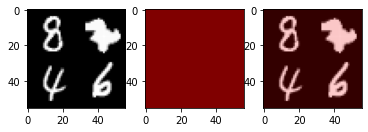

Image label is 0
Image text is There are 2 even number(s) in the image.
Prediction is 0.0 with confidence 0.9993292855797336


In [80]:
# Plot heatmap together with the image from ORIGINAL RESOLUTION
plot_image = cv2.merge((image_bytes,image_bytes,image_bytes))
updated_vision_heatmap = cv2.resize(np.array(vision_heatmap), (plot_image.shape[1], plot_image.shape[0]))
updated_vision_heatmap = np.uint8(255 * updated_vision_heatmap)
updated_vision_heatmap = cv2.applyColorMap(updated_vision_heatmap, cv2.COLORMAP_JET)
superimposed_img = updated_vision_heatmap * 0.5 + plot_image

f = plt.figure()
f.add_subplot(1, 3, 1)
plt.imshow(plot_image)
f.add_subplot(1, 3, 2)
plt.imshow(updated_vision_heatmap)
f.add_subplot(1, 3, 3)
plt.imshow(superimposed_img / np.max(superimposed_img))
plt.show(block=True)
print("Image label is", dataset["label"][index])
print("Image text is", dataset["text"][index])
print("Prediction is", prediction, "with confidence", confidence)

In [81]:
language_gradients = model.get_language_gradient()
pooled_language_gradients = torch.mean(language_gradients, dim=2)
pooled_language_gradients_np = pooled_language_gradients.detach().cpu().numpy()

In [82]:
# Only two words, so this indicate the importance of each word
print("Image text is: ", dataset["text"][index])
print("Corresponding Importance indicated by language gradient is", pooled_language_gradients_np[0])

Image text is:  There are 2 even number(s) in the image.
Corresponding Importance indicated by language gradient is [0.         0.00014561]


In [83]:
def mask_image(img,index_list):
    masked = np.zeros(img.shape)
    masked[:,:] = img
    for index in index_list:
        if index == 0:
            masked[0:28,0:28]=0
        elif index == 1:
            masked[0:28,28:-1]=0
        elif index == 2:
            masked[28:56,0:28]=0
        else:
            masked[28:-1,28:-1]=0
    return masked

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


There are 2 even number(s) in the image.
0


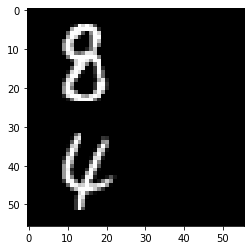

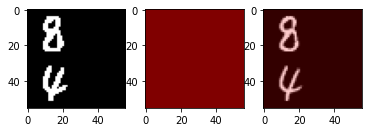

Image label is 0
Image text is There are 2 even number(s) in the image.
Prediction is 0.0 with confidence 0.9912032959982753


In [91]:
image_bytes = dataset["image"][index]
print(dataset['text'][index])
print(dataset['label'][index])
plt.imshow(image_bytes, cmap=plt.cm.gray)

masked_img = mask_image(image_bytes,[1,3])
plt.imshow(masked_img, cmap=plt.cm.gray)

cnn_inp = torch.from_numpy(np.expand_dims(np.expand_dims(masked_img.astype(np.float32) / 255, 0), 0))
cnn_inp = cnn_inp.to(DEVICE)
lstm_inp = torch.from_numpy(np.expand_dims(tokenized_texts[index], 0))
lstm_inp = lstm_inp.to(DEVICE)
output = model(cnn_inp, lstm_inp)
confidence = torch.sigmoid(output.squeeze()).detach().cpu().numpy().tolist()
prediction = torch.round(torch.sigmoid(output.squeeze())).detach().cpu().numpy().tolist()
if prediction == 0.0:
  confidence = 1 - confidence
output.backward()
vision_gradients = model.get_vision_gradient()
# pool the gradients across the channels, so that each channel have one gradient value
pooled_vision_gradients = torch.mean(vision_gradients, dim=[0, 2, 3])
pooled_vision_gradients_np = pooled_vision_gradients.detach().cpu().numpy()

# get the activations of the last convolutional layer
raw_vision_activations = model.get_vision_activations(cnn_inp)
vision_activations = np.zeros(raw_vision_activations.shape)

# weight the channels by corresponding gradients
for i in range(vision_activations[0].shape[0]):
  vision_activations[:, i, :, :] = raw_vision_activations[:, i, :, :] * pooled_vision_gradients_np[i]
    
# average the channels of the activations
vision_heatmap = torch.mean(torch.from_numpy(vision_activations), axis=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
vision_heatmap = np.maximum(vision_heatmap, 0)


# normalize the heatmap
vision_heatmap /= torch.max(vision_heatmap)
# Plot heatmap together with the image from ORIGINAL RESOLUTION
plot_image = cv2.merge((masked_img,masked_img,masked_img))
updated_vision_heatmap = cv2.resize(np.array(vision_heatmap), (plot_image.shape[1], plot_image.shape[0]))
updated_vision_heatmap = np.uint8(255 * updated_vision_heatmap)
updated_vision_heatmap = cv2.applyColorMap(updated_vision_heatmap, cv2.COLORMAP_JET)
superimposed_img = updated_vision_heatmap * 0.5 + plot_image

f = plt.figure()
f.add_subplot(1, 3, 1)
plt.imshow(plot_image)
f.add_subplot(1, 3, 2)
plt.imshow(updated_vision_heatmap)
f.add_subplot(1, 3, 3)
plt.imshow(superimposed_img / np.max(superimposed_img))
plt.show(block=True)
print("Image label is", dataset["label"][index])
print("Image text is", dataset["text"][index])
print("Prediction is", prediction, "with confidence", confidence)